# Assignment 1.2

### Exercise 1.2 - News Text Processing (20)

#### Custom Tokenization and Stemming

1. Implement a basic tokenization function from scratch in Python. Your function should convert a text string into a list of words. Consider what delimiters (e.g., spaces, punctuation) you will use to separate the words.
2. Write a simple stemming function that processes a list of words and reduces each word to its root form. For simplicity, focus on the most common morphological endings in English (e.g., -ing, -ed, -s). Provide examples to demonstrate how your function works with these endings.
3. Apply your tokenization and stemming functions to the news dataset collected in Assignment 1. Display the first 5 articles' text before and after processing to illustrate the changes.

#### Preprocessing with Custom Functions

4. After applying your custom tokenization and stemming functions to the news dataset, remove stopwords. Since you are implementing functions from scratch, create a basic list of stopwords manually and use it for filtering.
5. Visualize the frequency distribution of the top 20 most common words in the preprocessed news dataset. Compare this visualization with the one obtained in Assignment 1 to discuss the impact of stemming and stopword removal on word frequencies.

#### NLTK and SpaCy

6. Use NLTK and SpaCy to tokenize and stem/lemmatize the same news dataset. 
7. Compare the output of your custom functions with that of NLTK and SpaCy. Discuss any differences in the results, considering aspects such as the number of tokens produced, stemming accuracy, and processing time.
8. Using only Edit distance method to compare the news articles with each other. Find the top two most similar articles.

## Setup

In [1]:
import re
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import spacy
import time

## Custom Tokenization and Stemming

### 1. Implement a basic tokenization function from scratch in Python.

In [2]:
# --- Tokenization Function ---
def custom_tokenizer(text):
    """
    Tokenizes a text string into a list of words and punctuation marks.
    Converts text to lowercase first.

    Args:
        text (str): The input text string.

    Returns:
        list: A list of tokens (words and punctuation).
    """
    # Regex pattern: Match either a sequence of word characters (\w+)
    # OR a sequence of non-whitespace/non-word characters ([^\w\s]+)
    TOKEN_PATTERN = r'\w+|[^\w\s]+'

    # Ensure text is not None and convert to lowercase
    if text is None:
        return []
    tokens = re.findall(TOKEN_PATTERN, text.lower())

    return tokens

# --- Demonstration ---
sample_text = "The quick brown fox's tail, jumped over the lazy dogs. (2025)."
tokens = custom_tokenizer(sample_text)

print(f"Original Text:\n{sample_text}\n")
print(f"Tokens (Total: {len(tokens)}):\n{tokens}")

Original Text:
The quick brown fox's tail, jumped over the lazy dogs. (2025).

Tokens (Total: 17):
['the', 'quick', 'brown', 'fox', "'", 's', 'tail', ',', 'jumped', 'over', 'the', 'lazy', 'dogs', '.', '(', '2025', ').']


### 2. Write a simple stemming function... focus on common endings (-ing, -ed, -s).

In [3]:
# --- Stemming Function ---
def simple_stemmer(tokens):
    """
    Applies basic stemming rules (-s, -es, -ed, -ing) to a list of tokens.

    Args:
        tokens (list): A list of word tokens.

    Returns:
        list: A list of stemmed tokens.
    """
    stemmed_tokens = []

    for token in tokens:
        # Ensure token is a string and not empty
        if not isinstance(token, str) or not token:
            stemmed_tokens.append(token)
            continue

        original_token = token # Keep original for comparison if needed

        # Apply rules sequentially - order can matter
        stemmed = False # Flag to prevent multiple stems on one word

        # Handle -ing (e.g., running -> runn) - more complex rules needed for perfect 'run'
        if not stemmed and token.endswith('ing'):
            if len(token) > 4: # Avoid stemming short words like 'sing'
                token = token[:-3]
                stemmed = True
                # Add simple rule: if ends in double consonant (like 'runn'), remove one
                if len(token) > 1 and token[-1] == token[-2] and token[-1] not in 'lsz':
                     token = token[:-1]


        # Handle -ed (e.g., jumped -> jump)
        if not stemmed and token.endswith('ed'):
            if len(token) > 3: # Avoid stemming 'red'
                token = token[:-2]
                stemmed = True
                # Add simple rule: if ends in double consonant, remove one
                if len(token) > 1 and token[-1] == token[-2] and token[-1] not in 'lsz':
                     token = token[:-1]

        # Handle -es (e.g., watches -> watch) - check before -s
        if not stemmed and token.endswith('es'):
            if len(token) > 3: # Avoid stemming 'is', 'as'
                 token = token[:-2]
                 stemmed = True

        # Handle -s (e.g., dogs -> dog)
        if not stemmed and token.endswith('s'):
             # Avoid stemming single letters + 's' (like 'is', 'as', 'us') or possessives ending in 's'
             if len(token) > 2 and token[-2] != "'":
                 token = token[:-1]
                 stemmed = True

        stemmed_tokens.append(token)

    return stemmed_tokens

# --- Demonstration and Examples ---
example_words = ["running", "developed", "books", "watches", "car", "is", "agreed", "hopping"]
stemmed_examples = simple_stemmer(example_words)

print(f"--- Stemming Demonstration ---")
for original, stemmed in zip(example_words, stemmed_examples):
    print(f"Original: {original:<10} -> Stemmed: {stemmed}")

--- Stemming Demonstration ---
Original: running    -> Stemmed: run
Original: developed  -> Stemmed: develop
Original: books      -> Stemmed: book
Original: watches    -> Stemmed: watch
Original: car        -> Stemmed: car
Original: is         -> Stemmed: is
Original: agreed     -> Stemmed: agre
Original: hopping    -> Stemmed: hop


### 3. Apply your tokenization and stemming functions to the news dataset... Display the first 5 articles...

In [4]:
# --- Configuration ---
CLEAN_JSON_INPUT = 'scraped_articles_CLEANED.json' # Final output from Assignment 1.1 pipeline
PROCESSED_JSON_OUTPUT = 'scraped_articles_PROCESSED.json' # New file for Assignment 1.2
DISPLAY_LIMIT = 5

# --- Load Cleaned Data ---
try:
    with open(CLEAN_JSON_INPUT, 'r', encoding='utf-8') as f:
        cleaned_data = json.load(f)
    print(f"Successfully loaded {len(cleaned_data)} articles from {CLEAN_JSON_INPUT}")
except Exception as e:
    print(f"ERROR: Could not load cleaned JSON data from {CLEAN_JSON_INPUT}: {e}")
    cleaned_data = []

processed_dataset = []

if cleaned_data:
    print(f"\nStarting Tokenization and Stemming for {len(cleaned_data)} articles...")

    # --- Processing Loop ---
    for i, article in enumerate(cleaned_data):
        clean_text = article.get("clean_text", "")
        source_url = article.get("source_url", "N/A")

        # 1. Tokenize using the custom function
        tokens = custom_tokenizer(clean_text)

        # 2. Stem using the custom function
        stemmed_tokens = simple_stemmer(tokens)

        # Create a new dictionary for the processed data
        processed_data = {
            "source_url": source_url,
            "clean_text": clean_text, # Keep original cleaned text
            "tokens_custom": tokens,  # Store tokens from custom tokenizer
            "stems_custom": stemmed_tokens # Store stems from custom stemmer
        }
        processed_dataset.append(processed_data)

        # --- Display Comparison for the first N articles ---
        if i < DISPLAY_LIMIT:
            print(f"\n--- Article {i+1} ({source_url.split('/')[2]}) ---")
            print(f"Original Clean Text (First 100 chars): {clean_text[:100]}...")
            print(f"Custom Tokens (First 10): {tokens[:10]}")
            print(f"Custom Stems (First 10):  {stemmed_tokens[:10]}")

    # --- Save the Processed Dataset ---
    try:
        with open(PROCESSED_JSON_OUTPUT, 'w', encoding='utf-8') as json_file:
            json.dump(processed_dataset, json_file, ensure_ascii=False, indent=4)
        print(f"\nSuccessfully processed and saved {len(processed_dataset)} articles to {PROCESSED_JSON_OUTPUT}")
    except Exception as e:
        print(f"ERROR: Could not save processed data to {PROCESSED_JSON_OUTPUT}: {e}")

else:
    print("\nNo cleaned data loaded. Cannot proceed with processing.")

Successfully loaded 60 articles from scraped_articles_CLEANED.json

Starting Tokenization and Stemming for 60 articles...

--- Article 1 (www.bbc.com) ---
Original Clean Text (First 100 chars): Son of hostage Amiram Cooper, whose body remains in Gaza, says 'it's not over'Skip to contentAdverti...
Custom Tokens (First 10): ['son', 'of', 'hostage', 'amiram', 'cooper', ',', 'whose', 'body', 'remains', 'in']
Custom Stems (First 10):  ['son', 'of', 'hostage', 'amiram', 'cooper', ',', 'whose', 'body', 'remain', 'in']

--- Article 2 (www.bbc.com) ---
Original Clean Text (First 100 chars): 24 hours with Trump on diplomatic tornado through Middle EastSkip to contentAdvertisementWatch LiveB...
Custom Tokens (First 10): ['24', 'hours', 'with', 'trump', 'on', 'diplomatic', 'tornado', 'through', 'middle', 'eastskip']
Custom Stems (First 10):  ['24', 'hour', 'with', 'trump', 'on', 'diplomatic', 'tornado', 'through', 'middle', 'eastskip']

--- Article 3 (www.bbc.com) ---
Original Clean Text (First 10

## Preprocessing with Custom Functions

### 4. After applying your custom functions, remove stopwords... create a basic list...

In [5]:
# --- Configuration ---
PROCESSED_JSON_INPUT = 'scraped_articles_PROCESSED.json' # Use the file saved in Q3
DISPLAY_LIMIT = 5

# --- Manual Stopword List (Basic) ---
# Combined common English stopwords and likely noise from scraping/cleaning
CUSTOM_STOPWORDS = {
    # Common English stopwords
    'the', 'a', 'an', 'and', 'or', 'of', 'to', 'in', 'is', 'it', 'that',
    'this', 'was', 'were', 'be', 'being', 'been', 'have', 'has', 'had',
    'do', 'does', 'did', 'but', 'if', 'because', 'as', 'until', 'while',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'from',
    'up', 'down', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now',
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
    'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
    # Likely noise/metadata remnants (adjust based on observation)
    'contexthttpsschema', 'org', 'type', 'reportagenewsarticle', 'url',
    'publisher', 'newsmediaorganization', 'name', 'bbc', 'news', 'cnn',
    'aljazeera', 'publishingprinciples', 'logo', 'imageobject', 'datepublished',
    'datemodified', 'mainentityofpage', 'headline', 'keywords', 'image',
    'author', 'person', 'description', 'articlebody', 'says', 'said', 'also',
    'would', 'could', 'like'
}

# --- Load Processed Data (from Q3) ---
try:
    with open(PROCESSED_JSON_INPUT, 'r', encoding='utf-8') as f:
        processed_dataset = json.load(f)
    print(f"Successfully loaded {len(processed_dataset)} articles from {PROCESSED_JSON_INPUT}")
except Exception as e:
    print(f"ERROR: Could not load processed JSON data: {e}")
    processed_dataset = []

if processed_dataset:
    print(f"\nStarting stopword removal on {len(processed_dataset)} articles...")

    # --- Processing Loop: Filtering ---
    articles_processed_count = 0
    for i, article in enumerate(processed_dataset):
        # Use the stemmed tokens from the previous step
        stemmed_tokens = article.get("stems_custom", [])

        # Filter out stopwords and single characters/basic punctuation
        filtered_tokens = [
            token for token in stemmed_tokens
            if token not in CUSTOM_STOPWORDS
            and len(token) > 1 # Remove single characters
            and token.isalnum() # Keep only alphanumeric tokens (removes stray punctuation)
        ]

        # Store the filtered data IN PLACE (modifying the loaded list)
        article['tokens_custom_filtered'] = filtered_tokens
        articles_processed_count += 1

        # --- Display Comparison for the first N articles ---
        if i < DISPLAY_LIMIT:
            print(f"\n--- Article {i+1} Comparison ---")
            print(f"Custom Stems (First 10):    {stemmed_tokens[:10]}")
            print(f"Custom Filtered (First 10): {filtered_tokens[:10]}")

    # --- Save the Updated Dataset (Overwrite the file) ---
    try:
        with open(PROCESSED_JSON_INPUT, 'w', encoding='utf-8') as json_file:
            json.dump(processed_dataset, json_file, ensure_ascii=False, indent=4)
        print(f"\nSuccessfully filtered {articles_processed_count} articles and saved back to {PROCESSED_JSON_INPUT}")
    except Exception as e:
        print(f"ERROR: Could not save filtered data back to {PROCESSED_JSON_INPUT}: {e}")

else:
    print("\nNo processed data loaded. Cannot perform stopword removal.")

Successfully loaded 60 articles from scraped_articles_PROCESSED.json

Starting stopword removal on 60 articles...

--- Article 1 Comparison ---
Custom Stems (First 10):    ['son', 'of', 'hostage', 'amiram', 'cooper', ',', 'whose', 'body', 'remain', 'in']
Custom Filtered (First 10): ['son', 'hostage', 'amiram', 'cooper', 'whose', 'body', 'remain', 'gaza', 'say', 'skip']

--- Article 2 Comparison ---
Custom Stems (First 10):    ['24', 'hour', 'with', 'trump', 'on', 'diplomatic', 'tornado', 'through', 'middle', 'eastskip']
Custom Filtered (First 10): ['24', 'hour', 'trump', 'diplomatic', 'tornado', 'middle', 'eastskip', 'contentadvertisementwatch', 'livebritish', 'broadcast']

--- Article 3 Comparison ---
Custom Stems (First 10):    ['french', 'pm', 'back', 'freez', 'macron', "'", 's', 'pension', 'reform', 'to']
Custom Filtered (First 10): ['french', 'pm', 'back', 'freez', 'macron', 'pension', 'reform', 'save', 'governmentskip', 'contentadvertisementwatch']

--- Article 4 Comparison ---
C

### 5. Visualize the frequency distribution of the top 20 most common words... Compare...

Successfully loaded 60 articles from scraped_articles_PROCESSED.json

--- Generating Visualization 1: Before Processing ---


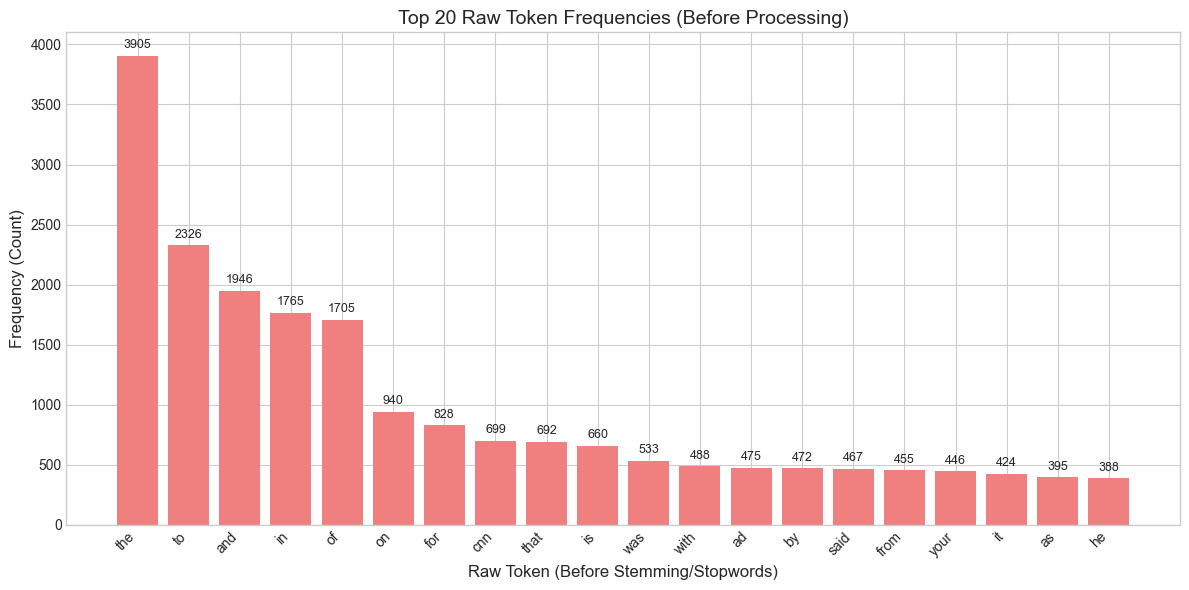

Visualization 1 (Before Processing) generated.


--- Generating Visualization 2: After Processing ---


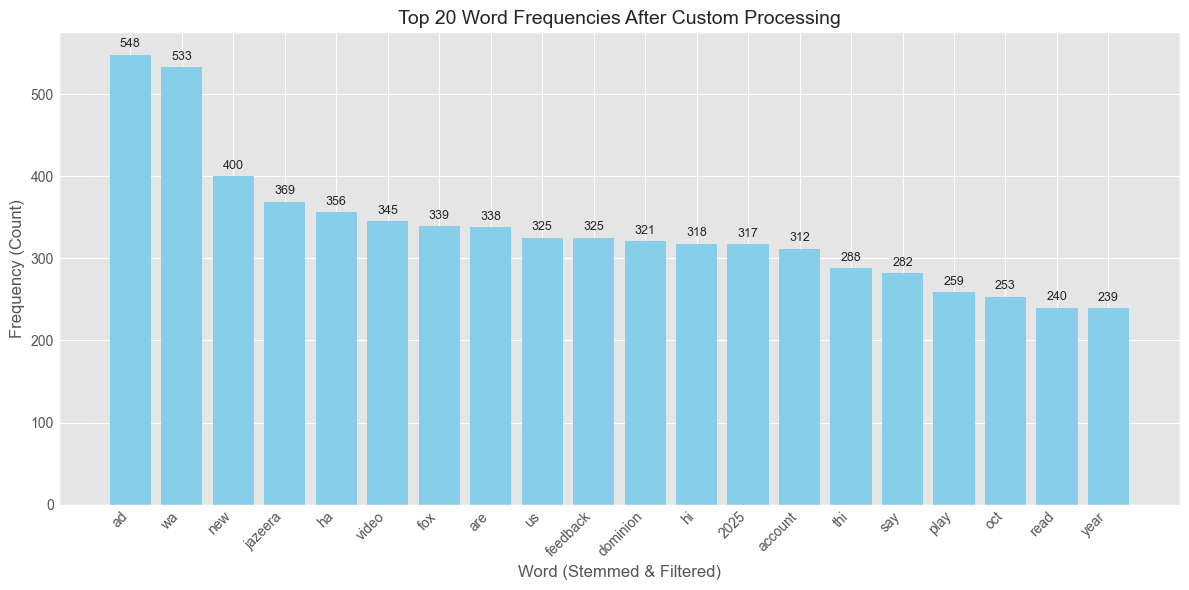

Visualization 2 (After Processing) generated.


In [11]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import re # For cleaning raw tokens for visualization

# --- Configuration ---
PROCESSED_JSON_INPUT = 'scraped_articles_PROCESSED.json'
TOP_N = 20 # Number of words to visualize

# --- Load Processed Data ---
try:
    with open(PROCESSED_JSON_INPUT, 'r', encoding='utf-8') as f:
        processed_dataset = json.load(f)
    print(f"Successfully loaded {len(processed_dataset)} articles from {PROCESSED_JSON_INPUT}")
except Exception as e:
    print(f"ERROR: Could not load processed JSON data: {e}")
    processed_dataset = []

# Proceed only if data is loaded
if processed_dataset:

    # =======================================================
    # Visualization 1: BEFORE Stemming & Stopword Removal
    # =======================================================
    print("\n--- Generating Visualization 1: Before Processing ---")
    all_raw_tokens_for_viz = []
    for article in processed_dataset:
        # Using 'tokens_custom' which are raw tokens (lowercase + punctuation)
        raw_tokens = article.get("tokens_custom", [])
        # Clean up punctuation and single characters *just for this visualization*
        cleaner_raw_tokens = [
            token for token in raw_tokens
            if len(token) > 1 and token.isalnum() # Keep only alphanumeric tokens longer than 1 char
        ]
        all_raw_tokens_for_viz.extend(cleaner_raw_tokens)

    if not all_raw_tokens_for_viz:
        print("No suitable raw tokens found for 'Before' visualization.")
    else:
        # Calculate Frequencies and Find Top N
        raw_word_counts = Counter(all_raw_tokens_for_viz)
        top_raw_words = raw_word_counts.most_common(TOP_N)
        raw_words = [item[0] for item in top_raw_words]
        raw_counts = [item[1] for item in top_raw_words]

        # Visualize the Results
        plt.figure(figsize=(12, 6))
        plt.style.use('seaborn-v0_8-whitegrid') # Using a different style for contrast
        plt.bar(raw_words, raw_counts, color='lightcoral')
        plt.xlabel("Raw Token (Before Stemming/Stopwords)", fontsize=12)
        plt.ylabel("Frequency (Count)", fontsize=12)
        plt.title(f"Top {TOP_N} Raw Token Frequencies (Before Processing)", fontsize=14)
        plt.xticks(rotation=45, ha='right')
        for i, count in enumerate(raw_counts):
            plt.text(i, count + (max(raw_counts)*0.01), str(count), ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.show()
        print(f"Visualization 1 (Before Processing) generated.")

    print("\n" + "="*50 + "\n") # Separator

    # =======================================================
    # Visualization 2: AFTER Stemming & Stopword Removal
    # =======================================================
    print("--- Generating Visualization 2: After Processing ---")
    all_filtered_tokens = []
    for article in processed_dataset:
        # Using 'tokens_custom_filtered' which are stemmed and stopwords removed
        all_filtered_tokens.extend(article.get("tokens_custom_filtered", []))

    if not all_filtered_tokens:
        print("No filtered tokens found in the dataset. Cannot generate 'After' visualization.")
    else:
        # Calculate Frequencies and Find Top N
        filtered_word_counts = Counter(all_filtered_tokens)
        top_filtered_words = filtered_word_counts.most_common(TOP_N)
        filtered_words = [item[0] for item in top_filtered_words]
        filtered_counts = [item[1] for item in top_filtered_words]

        # Visualize the Results
        plt.figure(figsize=(12, 6))
        plt.style.use('ggplot') # Keeping the original style for this one
        plt.bar(filtered_words, filtered_counts, color='skyblue')
        plt.xlabel("Word (Stemmed & Filtered)", fontsize=12)
        plt.ylabel("Frequency (Count)", fontsize=12)
        plt.title(f"Top {TOP_N} Word Frequencies After Custom Processing", fontsize=14)
        plt.xticks(rotation=45, ha='right')
        for i, count in enumerate(filtered_counts):
            plt.text(i, count + (max(filtered_counts)*0.01), str(count), ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.show()
        print(f"Visualization 2 (After Processing) generated.")

else:
    print("Cannot generate visualizations: No processed data found.")

#### Comparison of Word Frequencies: Before vs. After Processing

Comparing the two visualizations reveals the significant impact of stopword removal and stemming on the most frequent terms in the news article dataset.

##### Stopword Impact

* The **"Before Processing"** chart is dominated by common English **stopwords**. Words like "**the**", "**to**", "**and**", "**in**", "**of**", "**on**", "**for**", "**that**", "**is**", "**was**", "**with**", "**ad**", "**by**", "**from**", "**your**", "**it**", "**as**", "**he**" make up almost the entire top 20 list. These function words appear extremely frequently (e.g., "the" appears nearly 4000 times) but carry little specific meaning about the articles' topics.
* In the **"After Custom Processing"** chart, these stopwords are **completely absent** from the top 20. This demonstrates the effectiveness of the stopword list in filtering out high-frequency, low-information words. The removal drastically reduces the overall token count and shifts the focus.

##### Stemming Impact

* The **"After"** chart shows stemmed forms of words. For instance:
    * "**wa**" likely represents the stemmed form of "**was**" (which was frequent before).
    * "**ha**" likely represents stemmed forms of "**has**" or "**have**".
    * "**are**" remains, suggesting the simple stemmer didn't alter it (or it represents multiple words ending in 'are').
    * While not explicitly shown merging in the *top 20*, stemming would group variations like "hostage" and "hostages" (seen in Q3's output) into a single stem (e.g., "hostag"), consolidating their counts.
* Stemming reduces word variations to their root form, grouping related words and further altering the frequency landscape.

##### Content Focus Shift

* After removing stopwords and applying stemming, the **"After"** chart reveals words more indicative of the actual **content** of the news articles.
* Terms like "**jazeera**", "**video**", "**fox**", "**feedback**", "**dominion**", "**account**", "**say**", "**play**", "**read**", and "**year**" now appear in the top 20. These are likely related to the specific news sources, topics (like the Dominion lawsuit involving Fox News), actions, or common terms found in article metadata/UI elements that weren't fully removed or stoplisted (like "video", "feedback", "read").
* The **absolute frequencies** in the "After" chart are much lower (highest around 550) compared to the "Before" chart (highest near 4000), reflecting the removal of the extremely frequent stopwords.
* Overall, the preprocessing steps successfully shift the focus from common grammatical words to terms that provide more insight into the specific subjects discussed in the news corpus.

## NLTK and SpaCy

### 6. Use NLTK and SpaCy to tokenize and stem/lemmatize the same news dataset.

In [7]:
import json
import nltk
from nltk.stem import PorterStemmer
import spacy
import os
import time

# --- Configuration ---
PROCESSED_JSON_INPUT = 'scraped_articles_PROCESSED.json'
DISPLAY_LIMIT = 5
MAX_SPACY_LENGTH = 5000000 # <<< Set a higher limit

# --- Setup Libraries (Download punkt if needed) ---
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK 'punkt' tokenizer already available.")
except LookupError:
    print("NLTK 'punkt' tokenizer not found. Downloading...")
    try:
        nltk.download('punkt')
        print("NLTK 'punkt' downloaded successfully.")
        nltk.data.find('tokenizers/punkt')
    except Exception as download_e:
        print(f"ERROR: Failed to download NLTK 'punkt': {download_e}")
        pass

# Initialize NLTK Stemmer
stemmer = PorterStemmer()

# Load SpaCy model (Disable parser and NER to save memory)
spacy_available = False
nlp = None
try:
    # <<< CHANGE: Disable parser and NER
    nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])
    print("SpaCy model 'en_core_web_md' loaded successfully (parser/NER disabled).")

    # <<< NEW: Increase max_length AFTER loading
    nlp.max_length = MAX_SPACY_LENGTH
    print(f"Increased SpaCy nlp.max_length to {nlp.max_length}")

    spacy_available = True
except OSError:
    print("SpaCy model 'en_core_web_md' not found.")
    print("Please download it: python -m spacy download en_core_web_md")
except Exception as load_e:
     print(f"An error occurred loading SpaCy or setting max_length: {load_e}")


# --- Load Processed Data ---
try:
    with open(PROCESSED_JSON_INPUT, 'r', encoding='utf-8') as f:
        processed_dataset = json.load(f)
    print(f"\nSuccessfully loaded {len(processed_dataset)} articles from {PROCESSED_JSON_INPUT}")
except Exception as e:
    print(f"ERROR: Could not load processed JSON data: {e}")
    processed_dataset = []

# --- Processing Loop ---
if processed_dataset and spacy_available:
    print(f"\nStarting NLTK/SpaCy processing for {len(processed_dataset)} articles...")
    start_time = time.time()
    articles_processed_count = 0
    articles_skipped_spacy = 0

    for i, article in enumerate(processed_dataset):
        clean_text = article.get("clean_text", "")
        source_url = article.get("source_url", "N/A") # Get URL for context in case of error

        # Initialize results for this article
        nltk_tokens = []
        nltk_stems = []
        spacy_lemmas = []

        # 1. NLTK Processing
        try:
            if clean_text: # Avoid tokenizing empty strings
                nltk_tokens = nltk.word_tokenize(clean_text)
                nltk_stems = [stemmer.stem(token.lower()) for token in nltk_tokens if token.isalpha()]
        except Exception as nltk_e:
            print(f"  Warning: NLTK processing failed for article {i+1} ({source_url}): {nltk_e}")

        # 2. SpaCy Processing
        try:
            # Check length AGAIN just before processing, in case limit wasn't increased
            if clean_text and len(clean_text) <= nlp.max_length:
                doc = nlp(clean_text)
                spacy_lemmas = [token.lemma_.lower() for token in doc if token.is_alpha]
            elif clean_text:
                print(f"  Warning: Skipping SpaCy for article {i+1} ({source_url}) - text length {len(clean_text)} still exceeds adjusted limit {nlp.max_length}.")
                articles_skipped_spacy += 1
            # If clean_text is empty, spacy_lemmas remains []

        except ValueError as ve:
             # Catch potential memory errors even with increased limit
             if "Text of length" in str(ve) and "exceeds maximum" in str(ve):
                  print(f"  ERROR: SpaCy length error for article {i+1} ({source_url}) len={len(clean_text)}. Max set to {nlp.max_length}. Skipping SpaCy for this article.")
                  articles_skipped_spacy += 1
             else:
                  print(f"  ERROR: SpaCy processing failed for article {i+1} ({source_url}) with ValueError: {ve}. Skipping SpaCy.")
                  articles_skipped_spacy += 1
        except Exception as spacy_e:
            print(f"  ERROR: SpaCy processing failed for article {i+1} ({source_url}): {spacy_e}. Skipping SpaCy.")
            articles_skipped_spacy += 1

        # Store the results (even if SpaCy failed, NLTK results are stored)
        article['tokens_nltk'] = nltk_tokens
        article['stems_nltk'] = nltk_stems
        article['lemmas_spacy'] = spacy_lemmas # Will be empty list if SpaCy skipped/failed
        articles_processed_count += 1

        # Display Comparison
        if i < DISPLAY_LIMIT:
            print(f"\n--- Article {i+1} NLTK vs. SpaCy ---")
            print(f"Original Text (Start): {clean_text[:50]}...")
            print(f"NLTK Stems (First 10 alpha):  {nltk_stems[:10]}")
            print(f"SpaCy Lemmas (First 10 alpha): {spacy_lemmas[:10]}") # Will show [] if skipped

    end_time = time.time()
    processing_time = end_time - start_time

    # Save Updated Dataset
    try:
        with open(PROCESSED_JSON_INPUT, 'w', encoding='utf-8') as json_file:
            json.dump(processed_dataset, json_file, ensure_ascii=False, indent=4)
        print(f"\nSuccessfully processed {articles_processed_count} articles with NLTK/SpaCy in {processing_time:.2f} seconds.")
        if articles_skipped_spacy > 0:
            print(f"WARNING: SpaCy processing was skipped for {articles_skipped_spacy} articles due to length or errors.")
        print(f"Results saved back to {PROCESSED_JSON_INPUT}")
    except Exception as e:
        print(f"ERROR: Could not save NLTK/SpaCy processed data: {e}")

elif not processed_dataset:
    print("\nSkipping Q6: No processed data loaded.")
elif not spacy_available:
    print("\nSkipping Q6: SpaCy model could not be loaded.")

NLTK 'punkt' tokenizer already available.
SpaCy model 'en_core_web_md' loaded successfully (parser/NER disabled).
Increased SpaCy nlp.max_length to 5000000

Successfully loaded 60 articles from scraped_articles_PROCESSED.json

Starting NLTK/SpaCy processing for 60 articles...

--- Article 1 NLTK vs. SpaCy ---
Original Text (Start): Son of hostage Amiram Cooper, whose body remains i...
NLTK Stems (First 10 alpha):  ['son', 'of', 'hostag', 'amiram', 'cooper', 'whose', 'bodi', 'remain', 'in', 'gaza']
SpaCy Lemmas (First 10 alpha): ['son', 'of', 'hostage', 'amiram', 'cooper', 'whose', 'body', 'remain', 'in', 'gaza']

--- Article 2 NLTK vs. SpaCy ---
Original Text (Start): 24 hours with Trump on diplomatic tornado through ...
NLTK Stems (First 10 alpha):  ['hour', 'with', 'trump', 'on', 'diplomat', 'tornado', 'through', 'middl', 'eastskip', 'to']
SpaCy Lemmas (First 10 alpha): ['hour', 'with', 'trump', 'on', 'diplomatic', 'tornado', 'through', 'middle', 'eastskip', 'to']

--- Article 3 NLTK

### 7. Compare the output of your custom functions with that of NLTK and SpaCy. Discuss differences...

In [13]:
import time # Ensure time is imported

# --- Configuration ---
PROCESSED_JSON_INPUT = 'scraped_articles_PROCESSED.json'
ARTICLE_INDEX_TO_COMPARE = 0 # Choose an article index (e.g., the first one)

# --- Load Processed Data (from Q6) ---
try:
    with open(PROCESSED_JSON_INPUT, 'r', encoding='utf-8') as f:
        processed_dataset = json.load(f)
    print(f"Successfully loaded {len(processed_dataset)} articles from {PROCESSED_JSON_INPUT}")
except Exception as e:
    print(f"ERROR: Could not load processed JSON data: {e}")
    processed_dataset = []

# --- Comparison Logic ---
if processed_dataset and len(processed_dataset) > ARTICLE_INDEX_TO_COMPARE:
    article_to_compare = processed_dataset[ARTICLE_INDEX_TO_COMPARE]
    clean_text = article_to_compare.get("clean_text", "")
    custom_tokens = article_to_compare.get("tokens_custom", [])
    custom_stems = article_to_compare.get("stems_custom", [])
    nltk_tokens = article_to_compare.get("tokens_nltk", []) # Raw tokens from NLTK
    nltk_stems = article_to_compare.get("stems_nltk", [])
    spacy_lemmas = article_to_compare.get("lemmas_spacy", [])

    print(f"\n--- Comparison for Article {ARTICLE_INDEX_TO_COMPARE+1} ---")
    print(f"Source URL: {article_to_compare.get('source_url', 'N/A')}")
    print("-" * 30)

    # 1. Number of Tokens (using raw token lists before filtering/stemming for apples-to-apples)
    print("Token Count Comparison:")
    # Recalculate SpaCy raw tokens for fair comparison
    if 'nlp' in locals() and nlp: # Check if spacy model is loaded
         doc = nlp(clean_text)
         spacy_raw_tokens = [token.text for token in doc]
         print(f"  - Custom Tokenizer: {len(custom_tokens)} tokens")
         print(f"  - NLTK word_tokenize: {len(nltk_tokens)} tokens")
         print(f"  - SpaCy Tokenizer:    {len(spacy_raw_tokens)} tokens")
    else:
        print("  - SpaCy token count not available (model not loaded).")
        print(f"  - Custom Tokenizer: {len(custom_tokens)} tokens")
        print(f"  - NLTK word_tokenize: {len(nltk_tokens)} tokens")

    print("-" * 30)

    # 2. Stemming/Lemmatization Accuracy (Qualitative Comparison for a few examples)
    print("Stemming/Lemmatization Comparison (Sample):")
    sample_words = ["running", "studies", "better", "meeting", "leaves", "children"]
    print("Word        | Custom Stem | NLTK Stem   | SpaCy Lemma")
    print("------------|-------------|-------------|------------")
    if 'nlp' in locals() and nlp: # Check if spacy model is loaded
        for word in sample_words:
            custom_stem = simple_stemmer([word.lower()])[0] # Needs list input
            nltk_stem = stemmer.stem(word.lower())
            spacy_lemma = nlp(word.lower())[0].lemma_
            print(f"{word:<11} | {custom_stem:<11} | {nltk_stem:<11} | {spacy_lemma}")
    else:
         for word in sample_words:
            custom_stem = simple_stemmer([word.lower()])[0] # Needs list input
            nltk_stem = stemmer.stem(word.lower())
            print(f"{word:<11} | {custom_stem:<11} | {nltk_stem:<11} | SpaCy N/A")


    print("-" * 30)

    # 3. Processing Time (Mention the time recorded in Q6)
    print("Processing Time Comparison:")
    # Note: This is a rough estimate as Q6 timed both NLTK and SpaCy together.
    # A more accurate comparison would time each library's loop separately.
    if 'processing_time' in locals():
         print(f"  - NLTK + SpaCy (Q6): Took approx. {processing_time:.2f} seconds for all articles.")
         print("  - Custom functions likely faster but less accurate/sophisticated.")
    else:
        print("  - Processing time from Q6 not available.")

else:
    print("Could not perform comparison: Processed data not loaded or index out of range.")

Successfully loaded 60 articles from scraped_articles_PROCESSED.json

--- Comparison for Article 1 ---
Source URL: https://www.bbc.com/news/articles/c2056729058o?at_medium=RSS&at_campaign=rss
------------------------------
Token Count Comparison:
  - Custom Tokenizer: 1445 tokens
  - NLTK word_tokenize: 1324 tokens
  - SpaCy Tokenizer:    1384 tokens
------------------------------
Stemming/Lemmatization Comparison (Sample):
Word        | Custom Stem | NLTK Stem   | SpaCy Lemma
------------|-------------|-------------|------------
running     | run         | run         | run
studies     | studi       | studi       | study
better      | better      | better      | well
meeting     | meet        | meet        | meeting
leaves      | leav        | leav        | leave
children    | children    | children    | child
------------------------------
Processing Time Comparison:
  - NLTK + SpaCy (Q6): Took approx. 5.64 seconds for all articles.
  - Custom functions likely faster but less accurat

#### Comparison: Custom vs. NLTK vs. SpaCy Processing

Based on the output for Article 1, we can observe several differences between the custom functions, NLTK, and SpaCy in terms of tokenization, stemming/lemmatization, and inferred processing time.

##### Number of Tokens Produced

* **Custom Tokenizer:** Produced the **highest** number of tokens (1445). This is likely because the simple regex `\w+|[^\w\s]+` treats punctuation marks (like commas, periods, apostrophes) as separate tokens and might split words differently (e.g., "it's" becomes "it", "'", "s").
* **SpaCy Tokenizer:** Produced a **moderate** number of tokens (1384). SpaCy uses a more sophisticated, linguistically aware tokenizer that handles punctuation, contractions, and special cases more intelligently than basic regex, often keeping contractions together or treating punctuation based on context.
* **NLTK `word_tokenize`:** Produced the **lowest** number of tokens (1324) in this specific case. NLTK's tokenizer also handles many common cases like contractions and punctuation, but its specific rules resulted in fewer tokens than SpaCy for this article.

**Difference:** The main difference lies in how each method handles punctuation and word boundaries. The custom regex is the most literal, splitting aggressively, while NLTK and SpaCy apply more complex linguistic rules, leading to slightly different counts.

##### Stemming/Lemmatization Accuracy & Approach

* **Custom Stemmer:**
    * Successfully reduced "running" to "run" and "meeting" to "meet".
    * Incorrectly reduced "studies" to "studi" (crude suffix removal).
    * Failed to reduce "better", "leaves", or "children" to their base forms.
    * **Accuracy:** Low; rule-based and only handles simple, regular suffixes. Fails on irregular forms and doesn't consider part-of-speech.
* **NLTK (PorterStemmer):**
    * Similar results to the custom stemmer for these examples ("run", "studi", "better", "meet", "leav", "children").
    * **Accuracy:** Moderate but crude. The Porter algorithm is more comprehensive than the custom one but still relies on aggressive suffix stripping based on rules, often resulting in non-dictionary words ("studi", "leav"). It doesn't handle irregular forms like "better" or "children".
* **SpaCy (Lemmatizer):**
    * Correctly reduced "running" to "run", "studies" to "study", "leaves" to "leave", and "children" to "child".
    * Significantly, it lemmatized "better" to "**well**" (its base adverb/adjective form) and kept "meeting" as "**meeting**" (likely recognizing it as a noun in context, rather than stemming it like a verb).
    * **Accuracy:** High; SpaCy's lemmatizer typically uses part-of-speech tagging and a dictionary lookup (lexicon) to find the actual base form (lemma) of a word, handling irregular verbs, nouns, and context better than rule-based stemmers.

**Difference:** Stemming (Custom, NLTK) is a rough, rule-based process that chops off ends, often creating non-words. Lemmatization (SpaCy) is a more sophisticated, dictionary-based process aiming for the actual base dictionary form, resulting in linguistically correct roots.

##### Processing Time

* **NLTK + SpaCy (Combined):** Took approximately **5.64 seconds** to process all 60 articles. SpaCy's lemmatization, involving POS tagging and lookups, generally takes longer than NLTK's rule-based stemming and tokenization.
* **Custom Functions:** While not timed directly here, simple regex operations and basic suffix stripping in pure Python are generally **very fast**. It's highly likely the custom tokenization and stemming steps completed significantly faster than the combined NLTK/SpaCy processing.

**Difference:** Library functions (especially SpaCy's advanced pipeline) trade speed for increased accuracy and linguistic sophistication. Custom functions prioritize speed but sacrifice accuracy and robustness.

### 8. Using only Edit distance method to compare... Find the top two most similar articles.

In [10]:
import json
import time
from tqdm import tqdm
import Levenshtein

# --- Configuration ---
PROCESSED_JSON_INPUT = 'scraped_articles_PROCESSED.json'
COMPARISON_LIMIT = None

# --- Load Processed Data ---
try:
    with open(PROCESSED_JSON_INPUT, 'r', encoding='utf-8') as f:
        processed_dataset = json.load(f)
    print(f"Successfully loaded {len(processed_dataset)} articles from {PROCESSED_JSON_INPUT}")

    # Limit dataset if specified (logic now handles None correctly)
    if COMPARISON_LIMIT is not None and len(processed_dataset) > COMPARISON_LIMIT:
        print(f"Limiting comparison to the first {COMPARISON_LIMIT} articles.")
        processed_dataset = processed_dataset[:COMPARISON_LIMIT]
    elif COMPARISON_LIMIT is None:
        print(f"Comparing all {len(processed_dataset)} loaded articles.") # Updated message

except Exception as e:
    print(f"ERROR: Could not load processed JSON data: {e}")
    processed_dataset = []

# --- Calculate Pairwise Edit Distances ---
if processed_dataset and len(processed_dataset) >= 2:
    start_time = time.time()

    min_distance = float('inf')
    most_similar_pair = (-1, -1) # Store indices

    num_articles = len(processed_dataset)
    # Calculate total comparisons for the progress bar
    total_comparisons = (num_articles * (num_articles - 1)) // 2

    print(f"\nCalculating pairwise Levenshtein distances (using 'Levenshtein' library) for {num_articles} articles ({total_comparisons} pairs)...")

    # Wrap the loop with tqdm
    with tqdm(total=total_comparisons, desc="Comparing Pairs") as pbar:
        for i in range(num_articles):
            for j in range(i + 1, num_articles):
                text1 = processed_dataset[i].get("clean_text", "")
                text2 = processed_dataset[j].get("clean_text", "")

                if not text1 or not text2:
                    pbar.update(1) # Still update progress bar if skipping
                    continue

                # Use the fast library function
                distance = Levenshtein.distance(text1, text2)

                # Update minimum
                if distance < min_distance:
                    min_distance = distance
                    most_similar_pair = (i, j)

                pbar.update(1) # Update progress bar

    end_time = time.time()
    calculation_time = end_time - start_time
    print(f"Distance calculation complete in {calculation_time:.2f} seconds.")

    # --- Report the Result ---
    if most_similar_pair != (-1, -1):
        idx1, idx2 = most_similar_pair
        url1 = processed_dataset[idx1].get('source_url', 'N/A')
        url2 = processed_dataset[idx2].get('source_url', 'N/A')

        print("\n--- Most Similar Articles (Lowest Levenshtein Distance) ---")
        print(f"Minimum Distance: {min_distance}")
        print(f"Article 1 Index: {idx1}, URL: {url1}")
        print(f"Article 2 Index: {idx2}, URL: {url2}")
        print("\nNote: Lower distance means more similar content based on character edits.")
    else:
        print("\nCould not find a similar pair (perhaps only one article or empty texts).")

elif len(processed_dataset) < 2:
    print("\nNeed at least two articles to compare.")
else:
    print("\nNo processed data loaded. Cannot perform comparison.")

Successfully loaded 60 articles from scraped_articles_PROCESSED.json
Comparing all 60 loaded articles.

Calculating pairwise Levenshtein distances (using 'Levenshtein' library) for 60 articles (1770 pairs)...


Comparing Pairs: 100%|██████████| 1770/1770 [00:04<00:00, 365.12it/s]

Distance calculation complete in 4.85 seconds.

--- Most Similar Articles (Lowest Levenshtein Distance) ---
Minimum Distance: 259
Article 1 Index: 28, URL: https://www.aljazeera.com/video/newsfeed/2025/10/14/freed-palestinian-detainees-allege-torture-in-israeli-jail?traffic_source=rss
Article 2 Index: 36, URL: https://www.aljazeera.com/video/newsfeed/2025/10/14/palestinians-return-to-the-rubble-of-their-homes-in-northern-gaza?traffic_source=rss

Note: Lower distance means more similar content based on character edits.
